In [1]:
from ddks.data import *
from ddks.data.openimages_dataset import LS
from ddks import methods
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import tqdm
import pickle
import os
plt.style.use('ah')
plt.show()


Bad key "mathtext.fallback" on line 27 in
/home/hage581/.config/matplotlib/stylelib/belle2_serif.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "mathtext.fallback" on line 36 in
/home/hage581/.config/matplotlib/stylelib/belle2.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
methods_list = [methods.ddks_method,  methods.onedks_method, methods.hotelling_method, methods.kldiv_method]
datasets = [GVM, GVS, DVU, Skew, MM, LS, DVUHighDim]

def within(x, y, eps=1.0E-3):
    return np.abs(x - y) < eps

def return_mean_significance(_method, Dataset, dimension, sample_size, permutations=100):
    _dataset = Dataset(dimension=dimension, sample_size=sample_size)
    p, t = next(_dataset)
    return _method(p, t, permutations)

def bisection(_method, Dataset, dimension, permutations=100, trials=10, max_sample_size=500):
    mids = []
    for i in tqdm.tqdm(np.arange(trials)):
        low = 2
        high = 100
        mid = int((low + high) / 2)
        low_sig = return_mean_significance(_method, Dataset, dimension, low, permutations)
        high_sig = return_mean_significance(_method, Dataset, dimension, high, permutations)
        mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
        significance = 1.0
        while not within(mid_sig, 0.05):
            if (high - low) <= 2:
                if (np.abs(high_sig - 0.05) < np.abs(mid_sig - 0.05)) \
                        and (np.abs(high_sig - 0.05) < np.abs(low_sig - 0.05)):
                    mid = high
                    mid_sig = high_sig
                elif (np.abs(low_sig - 0.05) < np.abs(mid_sig - 0.05)) \
                        and (np.abs(low_sig - 0.05) < np.abs(mid_sig - 0.05)):
                    mid = low
                    mid_sig = low_sig
                break
            if low_sig > 0.05 and mid_sig < 0.05:
                new_mid = int((low + mid) / 2)
                high = mid
                high_sig = mid_sig
                mid = new_mid
                mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
            elif mid_sig > 0.05 and high_sig < 0.05:
                new_mid = int((mid + high) / 2)
                low = mid
                low_sig = mid_sig
                mid = new_mid
                mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
            else:
                if high < max_sample_size:
                    high = high + 50
                    mid = int((low + high) / 2)
                    low_sig = return_mean_significance(_method, Dataset, dimension, low, permutations)
                    high_sig = return_mean_significance(_method, Dataset, dimension, high, permutations)
                    mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
                else:
                    mid = np.nan
                    break
        mids.append(mid)
    return np.nanmean(mids), np.nanstd(mids), np.sum(np.isfinite(mids))
        

In [3]:

if os.path.exists('ddks_dim_sample_sizes.pkl'):
    data = pickle.load(open('ddks_dim_sample_sizes.pkl', 'rb'))
else:
    data = {}
for dimension in np.arange(2, 6):
    if str(dimension) not in data.keys():
        data[str(dimension)] = dict()
    for dataset in datasets:
        if str(dataset) not in data[str(dimension)].keys():
            data[str(dimension)][str(dataset)] = dict()
        for metric in methods_list:
            if metric.name not in data[str(dimension)][str(dataset)].keys():
                data[str(dimension)][str(dataset)][metric.name] = bisection(metric, dataset, dimension=dimension)
                print(str(dimension), str(dataset), metric.name, data[str(dimension)][str(dataset)][metric.name])
                pickle.dump(data, open('ddks_dim_sample_sizes.pkl', 'wb'))


dict_keys(['2', '3', '4', '5', '6'])
dict_keys(["<class 'ddks.data.GVM'>", "<class 'ddks.data.GVS'>", "<class 'ddks.data.DVU'>", "<class 'ddks.data.Skew'>", "<class 'ddks.data.MM'>", "<class 'ddks.data.openimages_dataset.LS'>", "<class 'ddks.data.DVUHighDim'>"])
dict_keys(['ddKS', 'OnedKS', 'HotellingT2', 'KLDiv'])


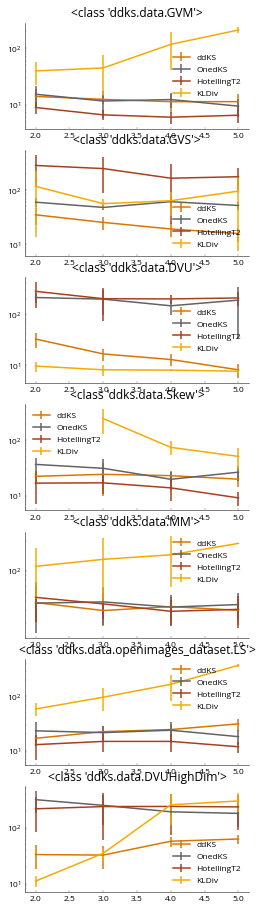

In [4]:
plt.figure(figsize=(4, 16))
plt.subplot(len(datasets)*100 + 11)
dimensions = data.keys()
datasets = data['4'].keys()
metrics = data['4']["<class 'ddks.data.DVU'>"].keys()
print(dimensions)
print(datasets)
print(metrics)
for i, _dataset in enumerate(datasets):
    plt.subplot(len(datasets)*100 + 11 + i)
    for metric in metrics:
        dimensions = [int(dimension) for dimension in data.keys() if dimension != '6']
        means = [data[str(dimension)][_dataset][metric][0] for dimension in dimensions]
        stds = [data[str(dimension)][_dataset][metric][1] for dimension in dimensions]
        plt.errorbar(dimensions, means, yerr=stds, label=metric)
    plt.title(_dataset)
    plt.legend()
    plt.semilogy()
plt.show()

ddKS
[0 1 2 3 4 5 6]
[12.25  23.875 17.525 22.3   42.925 23.75  46.2  ]
[-0.00736 -0.05128 -0.06152 -0.00704 -0.01592  0.036    0.09056]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5]
OnedKS
[0 1 2 3 4 5 6]
[ 12.15       55.35      185.26875    28.475      46.25       21.65
 232.8360119]
[-0.0136     -0.00832    -0.09658    -0.03336    -0.008      -0.0104
 -0.37064857]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5]
HotellingT2
[0 1 2 3 4 5 6]
[  7.         219.68571429 221.28452381  14.175       45.2
  13.575      230.71964286]
[-0.00624    -0.32795429 -0.17476952 -0.02104    -0.03728    -0.00264
  0.04353714]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5]
KLDiv
[0 1 2 3 4 5 6]
[102.55277778  83.34642857   8.325      123.66666667 143.3
 174.40833333 149.36666667]
[ 0.46534222 -0.04508571 -0.00488    -0.7792      0.19728     0.81586667
  0.8632    ]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5]


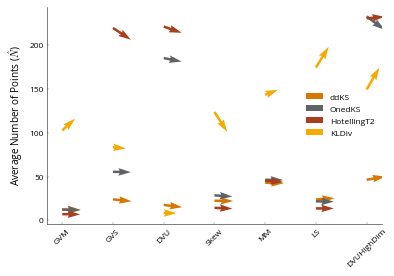

In [5]:
plt.figure(figsize=(6, 4))
colors = dict(ddKS='#D77600', OnedKS='#616265', HotellingT2='#A63F1E', KLDiv='#F4AA00')
for metric in metrics:
    ys = []
    dys = []
    for _dataset in datasets:
        dimensions = np.array([int(dimension) for dimension in data.keys() if dimension != '6'])
        means = np.array([data[str(dimension)][_dataset][metric][0] for dimension in dimensions])
        idx = np.argwhere(np.isfinite(means)).flatten()
        dimensions = dimensions[idx]
        means = means[idx]
        coeffs = np.polyfit(dimensions, means, 1)
        ys.append(np.mean(means))
        dys.append(coeffs[0])
    xs = np.arange(len(datasets))
    ys = np.array(ys)
    dys = 2.0 * np.array(dys) / 250.0
    dxs = 0.5 * np.ones_like(dys)
    print(metric)
    print(xs)
    print(ys)
    print(dys)
    print(dxs)
    plt.quiver(xs, ys, dxs, dys, color=colors[metric], label=metric)
plt.xticks(xs, [_dataset.split('.')[-1].replace("\'>", '') for _dataset in datasets], rotation=45)
plt.ylabel('Average Number of Points ($\hat{N}$)')
plt.legend()
plt.show()

[<matplotlib.lines.Line2D object at 0x7f9abb383f70>, <matplotlib.lines.Line2D object at 0x7f9abb29e730>, <matplotlib.lines.Line2D object at 0x7f9abb2a1040>, <matplotlib.lines.Line2D object at 0x7f9abab839d0>] [<matplotlib.collections.PolyCollection object at 0x7f9abb3830a0>, <matplotlib.collections.PolyCollection object at 0x7f9abb29ec70>, <matplotlib.collections.PolyCollection object at 0x7f9abb2a1550>, <matplotlib.collections.PolyCollection object at 0x7f9abab83e20>] ['ddKS', 'OnedKS', 'HotellingT2', 'KLDiv']


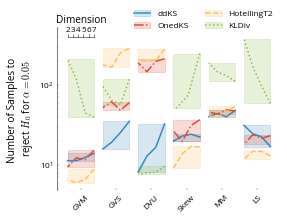

In [16]:
plt.figure(figsize=(4, 3))
lss = dict(ddKS='-', vdKS='--', rdKS=':', OnedKS='-.', HotellingT2='--', KLDiv=':')
['348ABD','E24A33', '988ED5', '777777', 'FBC15E', '8EBA42', 'FFB5B8']
colors = dict(ddKS='#D77600', OnedKS='#616265', HotellingT2='#A63F1E', KLDiv='#F4AA00')
colors = dict(ddKS='#348ABD', OnedKS='#E24A33', HotellingT2='#FBC15E', KLDiv='#8EBA42')
legend_markers = []
legend_lines = []
legend_titles = []
for metric in metrics:
    ys = []
    dys = []
    for i, _dataset in enumerate(datasets):
        if 'DVUHighDim' in _dataset:
            continue
        dimensions = np.array([int(dimension) for dimension in data.keys() if dimension != '6'])
        means = np.array([data[str(dimension)][_dataset][metric][0] for dimension in dimensions])
        idx = np.argwhere(np.isfinite(means)).flatten()
        dimensions = dimensions[idx]
        means = means[idx]
        coeffs = np.polyfit(dimensions, means, 1)
        pts_min = np.min(means)
        pts_max = np.max(means)
        plt.fill_between([i-0.375, i+0.375], [pts_min, pts_min], [pts_max, pts_max], color=colors[metric], alpha=0.2)
        plt.plot(i - 0.375 + 0.75 - np.arange(len(means)) /  float(len(means)), means, color=colors[metric], ls=lss[metric])
    line = plt.plot([0], [np.nan], color=colors[metric], ls=lss[metric])
    legend_lines.append(line[0])
    legend_markers.append(plt.fill_between([0, 1], [np.nan, np.nan], [np.nan, np.nan], color=colors[metric], alpha=0.2))
    legend_titles.append(metric)
plt.xticks(xs, [_dataset.split('.')[-1].replace("\'>", '') for _dataset in datasets], rotation=45)
plt.ylabel('Number of Samples to ' + "\n" + r'reject $H_{0}$ for $\alpha=0.05$')
print(legend_lines, legend_markers, legend_titles)
plt.legend([(ll, lm) for ll, lm in zip(legend_lines, legend_markers)], legend_titles, bbox_to_anchor=(1.0, 1.15), loc='upper right', ncol=2)
ymin, ymax = plt.gca().get_ylim()
plt.semilogy()
plt.plot([-0.375, 0.375], [ymax, ymax], color='black', lw=0.5)
for i in range(6):
    x = -0.375 + 0.75 * i / 5.0
    plt.plot([x, x], [ymax, ymax * 1.08], color='black', lw=0.5)
    plt.text(x, ymax * 1.1, str(i + 2), color='black', ha='center', va='bottom', fontsize=8)
plt.text(0, ymax * 1.4, 'Dimension', color='black', ha='center', va='bottom', fontsize=10)
plt.gca().spines['bottom'].set_visible(False)
plt.savefig('ddks_methods_dims.pdf', bbox_inches='tight')
plt.show()

In [7]:
!pwd

/raid/hage581/topgan/ddks/notebooks
